# Exercise 5

## Task 1

In [23]:
import torch
import torch.nn.functional as nn
import torch.autograd as autograd
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
from torch.autograd import Variable
import torchvision

In [18]:
data = torchvision.datasets.MNIST(root='data', train=True, transform=torchvision.transforms.ToTensor(), download=True)
loader = torch.utils.data.DataLoader(data, batch_size=60, shuffle=True, num_workers=2)

mb_size = 60
Z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128
c = 0
lr = 1e-3


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / np.sqrt(in_dim / 2.)
    return Variable(torch.randn(*size) * xavier_stddev, requires_grad=True)


""" ==================== GENERATOR ======================== """

Wzh = xavier_init(size=[Z_dim, h_dim])
bzh = Variable(torch.zeros(h_dim), requires_grad=True)

Whx = xavier_init(size=[h_dim, X_dim])
bhx = Variable(torch.zeros(X_dim), requires_grad=True)


def G(z):
    h = nn.relu(z @ Wzh + bzh.repeat(z.size(0), 1))
    X = torch.sigmoid(h @ Whx + bhx.repeat(h.size(0), 1))
    return X


""" ==================== DISCRIMINATOR ======================== """

Wxh = xavier_init(size=[X_dim, h_dim])
bxh = Variable(torch.zeros(h_dim), requires_grad=True)

Why = xavier_init(size=[h_dim, 1])
bhy = Variable(torch.zeros(1), requires_grad=True)


def D(X):
    h = nn.relu(X @ Wxh + bxh.repeat(X.size(0), 1))
    y = torch.sigmoid(h @ Why + bhy.repeat(h.size(0), 1))
    return y


G_params = [Wzh, bzh, Whx, bhx]
D_params = [Wxh, bxh, Why, bhy]
params = G_params + D_params


""" ===================== TRAINING ======================== """


def reset_grad():
    for p in params:
        if p.grad is not None:
            data = p.grad.data
            p.grad = Variable(data.new().resize_as_(data).zero_())


G_solver = optim.Adam(G_params, lr=1e-3)
D_solver = optim.Adam(D_params, lr=1e-3)

ones_label = Variable(torch.ones(mb_size, 1))
zeros_label = Variable(torch.zeros(mb_size, 1))

maxEpochs = 100;

iterations = 0
maxIterations = 20000
# max_iterations = 100000

dLoss, gLoss = [], []

for epoch in range(maxEpochs):
    if iterations == maxIterations:
      break 
    for i, (images, labels) in enumerate(loader): 
      if iterations == maxIterations:
        break 
      iterations += 1

      # Sample data
      z = Variable(torch.randn(mb_size, Z_dim))
      X = torch.reshape(images, (60,-1))
      X = Variable(X)

      # Dicriminator forward-loss-backward-update
      G_sample = G(z)
      D_real = D(X)
      D_fake = D(G_sample)

      D_loss = -torch.mean(torch.log(D_real) + torch.log(1. - D_fake)) # original loss

      # D_loss_real = nn.binary_cross_entropy(D_real, ones_label)
      # D_loss_fake = nn.binary_cross_entropy(D_fake, zeros_label)
      # D_loss = D_loss_real + D_loss_fake                                # logistic loss

      D_loss.backward()
      D_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # Generator forward-loss-backward-update
      z = Variable(torch.randn(mb_size, Z_dim))
      G_sample = G(z)
      D_fake = D(G_sample)


      G_loss = -torch.mean(torch.log(D_fake))                # original loss
      # G_loss = nn.binary_cross_entropy(D_fake, ones_label)    # logistic loss

      G_loss.backward()
      G_solver.step()

      # Housekeeping - reset gradient
      reset_grad()

      # Save loss for plot
      dLoss.append(D_loss.item())
      gLoss.append(G_loss.item())

      # Print and plot every now and then
      if iterations % 2000 == 0 or iterations == 1:
          print('Iter-{}; D_loss: {}; G_loss: {}'.format(iterations, D_loss.data.numpy(), G_loss.data.numpy()))

          samples = G(z).data.numpy()[:16]

          fig = plt.figure(figsize=(4, 4))
          gs = gridspec.GridSpec(4, 4)
          gs.update(wspace=0.05, hspace=0.05)

          for j, sample in enumerate(samples):
              ax = plt.subplot(gs[j])
              plt.axis('off')
              ax.set_xticklabels([])
              ax.set_yticklabels([])
              ax.set_aspect('equal')
              plt.imshow(sample.reshape(28, 28), cmap='Greys_r')

          if not os.path.exists('out/'):
              os.makedirs('out/')

          plt.savefig('out/{}--{}.png'.format(str(c).zfill(3), iterations), bbox_inches='tight')
          c += 1
          plt.close(fig)
        

Iter-1; D_loss: 1.6293247938156128; G_loss: 2.0355405807495117
Iter-2000; D_loss: 0.007447443436831236; G_loss: 6.965558052062988
Iter-4000; D_loss: 0.06544764339923859; G_loss: 4.964506149291992
Iter-6000; D_loss: 0.386603981256485; G_loss: 4.512312412261963
Iter-8000; D_loss: 0.4401994049549103; G_loss: 3.7447164058685303
Iter-10000; D_loss: 0.8004576563835144; G_loss: 3.4841315746307373
Iter-12000; D_loss: 0.9964443445205688; G_loss: 2.105043888092041
Iter-14000; D_loss: 0.6353952288627625; G_loss: 2.489680290222168
Iter-16000; D_loss: 0.5224835276603699; G_loss: 2.75390362739563
Iter-18000; D_loss: 0.7071662545204163; G_loss: 2.402113914489746
Iter-20000; D_loss: 0.8684597015380859; G_loss: 1.9431015253067017


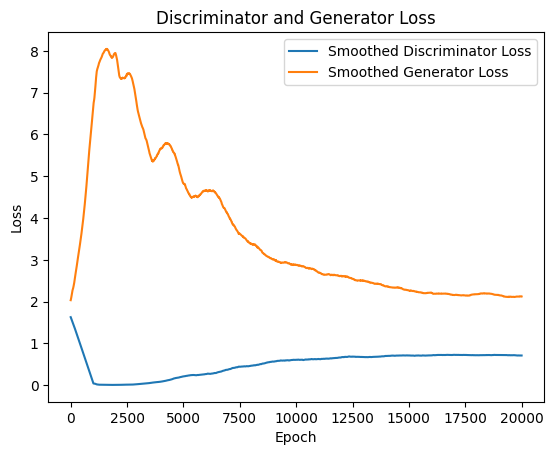

In [19]:
eRange = range(1, iterations+1)
fig, ax = plt.subplots()

window_size = 1000
padded_dLoss = np.concatenate(([dLoss[0]]*(window_size-1), dLoss))
padded_gLoss = np.concatenate(([gLoss[0]]*(window_size-1), gLoss))
rolling_mean_dLoss = np.convolve(padded_dLoss, np.ones(window_size)/window_size, mode='valid')
rolling_mean_gLoss = np.convolve(padded_gLoss, np.ones(window_size)/window_size, mode='valid')

# plot dLoss and gLoss with smoothed lines
ax.plot(eRange, rolling_mean_dLoss, label='Smoothed Discriminator Loss')
ax.plot(eRange, rolling_mean_gLoss, label='Smoothed Generator Loss')

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Discriminator and Generator Loss')

ax.legend()
plt.show()

In [21]:
!zip -r /content/out-20k-original-loss.zip /content/out

  adding: content/out/ (stored 0%)
  adding: content/out/010--20000.png (deflated 7%)
  adding: content/out/002--4000.png (deflated 7%)
  adding: content/out/000--1.png (deflated 5%)
  adding: content/out/007--14000.png (deflated 6%)
  adding: content/out/005--10000.png (deflated 7%)
  adding: content/out/006--12000.png (deflated 7%)
  adding: content/out/008--16000.png (deflated 7%)
  adding: content/out/001--2000.png (deflated 8%)
  adding: content/out/004--8000.png (deflated 7%)
  adding: content/out/003--6000.png (deflated 6%)
  adding: content/out/009--18000.png (deflated 7%)


## Task 2